In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set_style('darkgrid')
from collections import Counter
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')


## About the data: 
* Let’s consider a Company dataset with around 10 variables and 400 records. 
* The attributes are as follows: 
* Sales -- Unit sales (in thousands) at each location
* Competitor Price -- Price charged by competitor at each location
* Income -- Community income level (in thousands of dollars)
* Advertising -- Local advertising budget for company at each location (in thousands of dollars)
* Population -- Population size in region (in thousands)
* Price -- Price company charges for car seats at each site
* Shelf Location at stores -- A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
* Age -- Average age of the local population
* Education -- Education level at each location
* Urban -- A factor with levels No and Yes to indicate whether the store is in an urban or rural location
* US -- A factor with levels No and Yes to indicate whether the store is in the US or not
##### The company dataset looks like this: 
 
#### Problem Statement:
* A cloth manufacturing company is interested to know about the segment or attributes causes high sale. 
* Approach - A Random Forest can be built with target variable Sales (we will first convert it in categorical variable) & all other variable will be independent in the analysis.  


In [2]:
df = pd.read_csv('Company_Data RF(1).csv')
df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


## Data Exploration

In [3]:
df.isnull().any()

Sales          False
CompPrice      False
Income         False
Advertising    False
Population     False
Price          False
ShelveLoc      False
Age            False
Education      False
Urban          False
US             False
dtype: bool

In [4]:
df.isnull().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

## Descriptive Analysis

In [5]:
df.shape

(400, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [7]:
df[df.duplicated()].shape

(0, 11)

In [8]:
df[df.duplicated()]

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US


## Feature Engineering

In [9]:
df.Sales.describe()

count    400.000000
mean       7.496325
std        2.824115
min        0.000000
25%        5.390000
50%        7.490000
75%        9.320000
max       16.270000
Name: Sales, dtype: float64

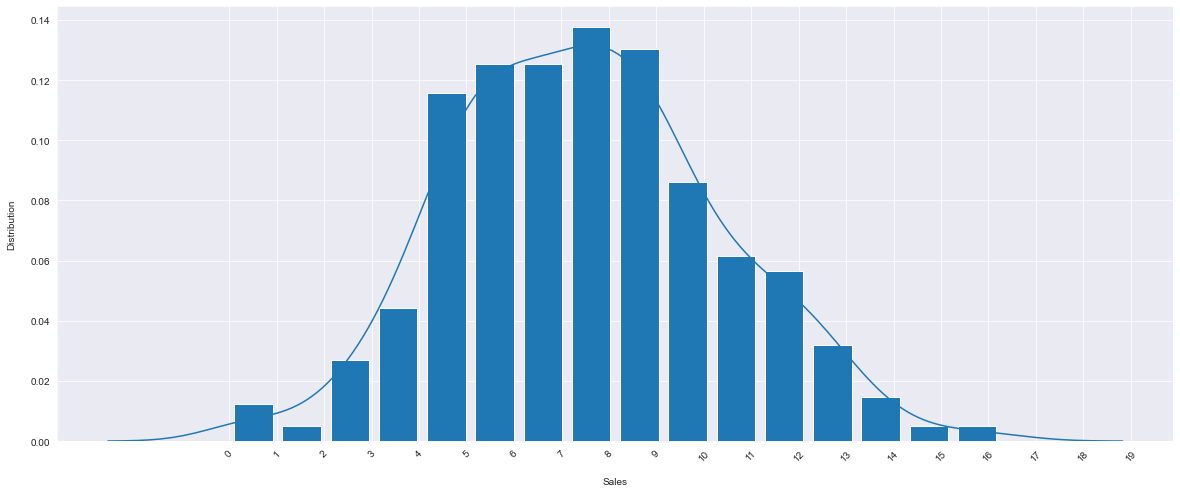

In [13]:
def distplot(param):
    plt.figure(figsize=(20,8))
    sns.distplot(df[param], hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xticks(np.arange(0,20,1),rotation=45)
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Sales")

### As the Sales distribution is not skewed and it is normal distribution we can take mean or median as a threshold to make two or three categories 'Low', 'Medium' and 'High' Sales
#### For two categories lets assume: Sales < 7.5 as “Bad=0” and Sales > 7.5 as “Good=1”
* and For three categories lets divide the Sales values with Quartiles , less than first quartile as 'Low' , between Second Quartile as 'Medium and above Third Quartile as 'High'

In [14]:
df.Sales.max()

16.27

In [15]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
df1=df.copy()
df1['Sales_cat'] = pd.cut(x = df1['Sales'], bins = [0,5.39,9.32,17], labels=['Low','Medium','High'], right = False)
df1.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,Sales_cat
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,High
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,High
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,High
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,Medium
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,Low


In [16]:
df1.Sales_cat.value_counts()

Medium    198
High      102
Low       100
Name: Sales_cat, dtype: int64

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    object  
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    object  
 10  US           400 non-null    object  
 11  Sales_cat    400 non-null    category
dtypes: category(1), float64(1), int64(7), object(3)
memory usage: 35.0+ KB


In [18]:
categorical_features = df1.describe(include=["object",'category']).columns
categorical_features

Index(['ShelveLoc', 'Urban', 'US', 'Sales_cat'], dtype='object')

In [19]:
numerical_features = df1.describe(include=["int64","float64"]).columns
numerical_features

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'Age', 'Education'],
      dtype='object')

##  Data Visualization


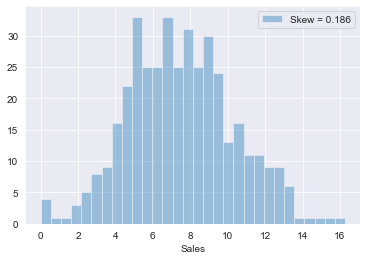

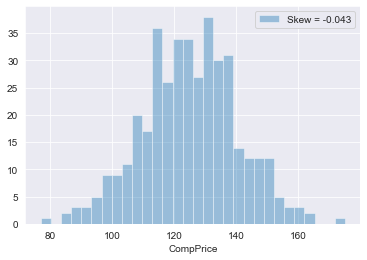

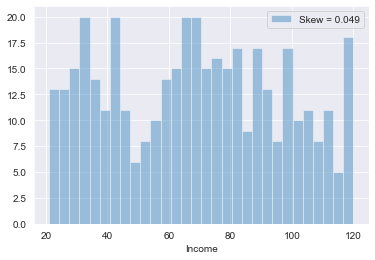

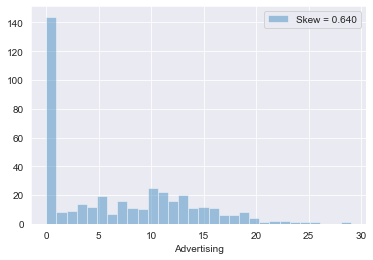

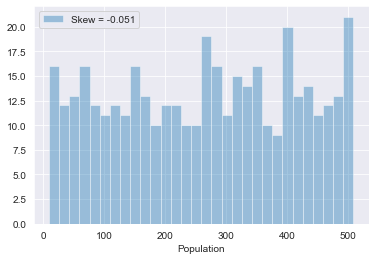

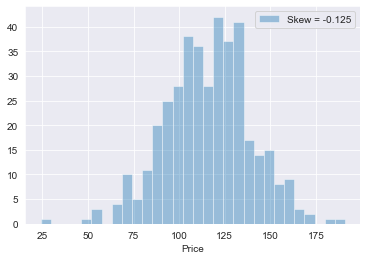

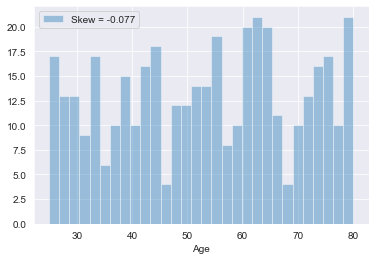

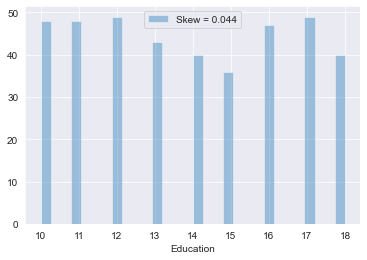

In [20]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

<Figure size 576x576 with 0 Axes>

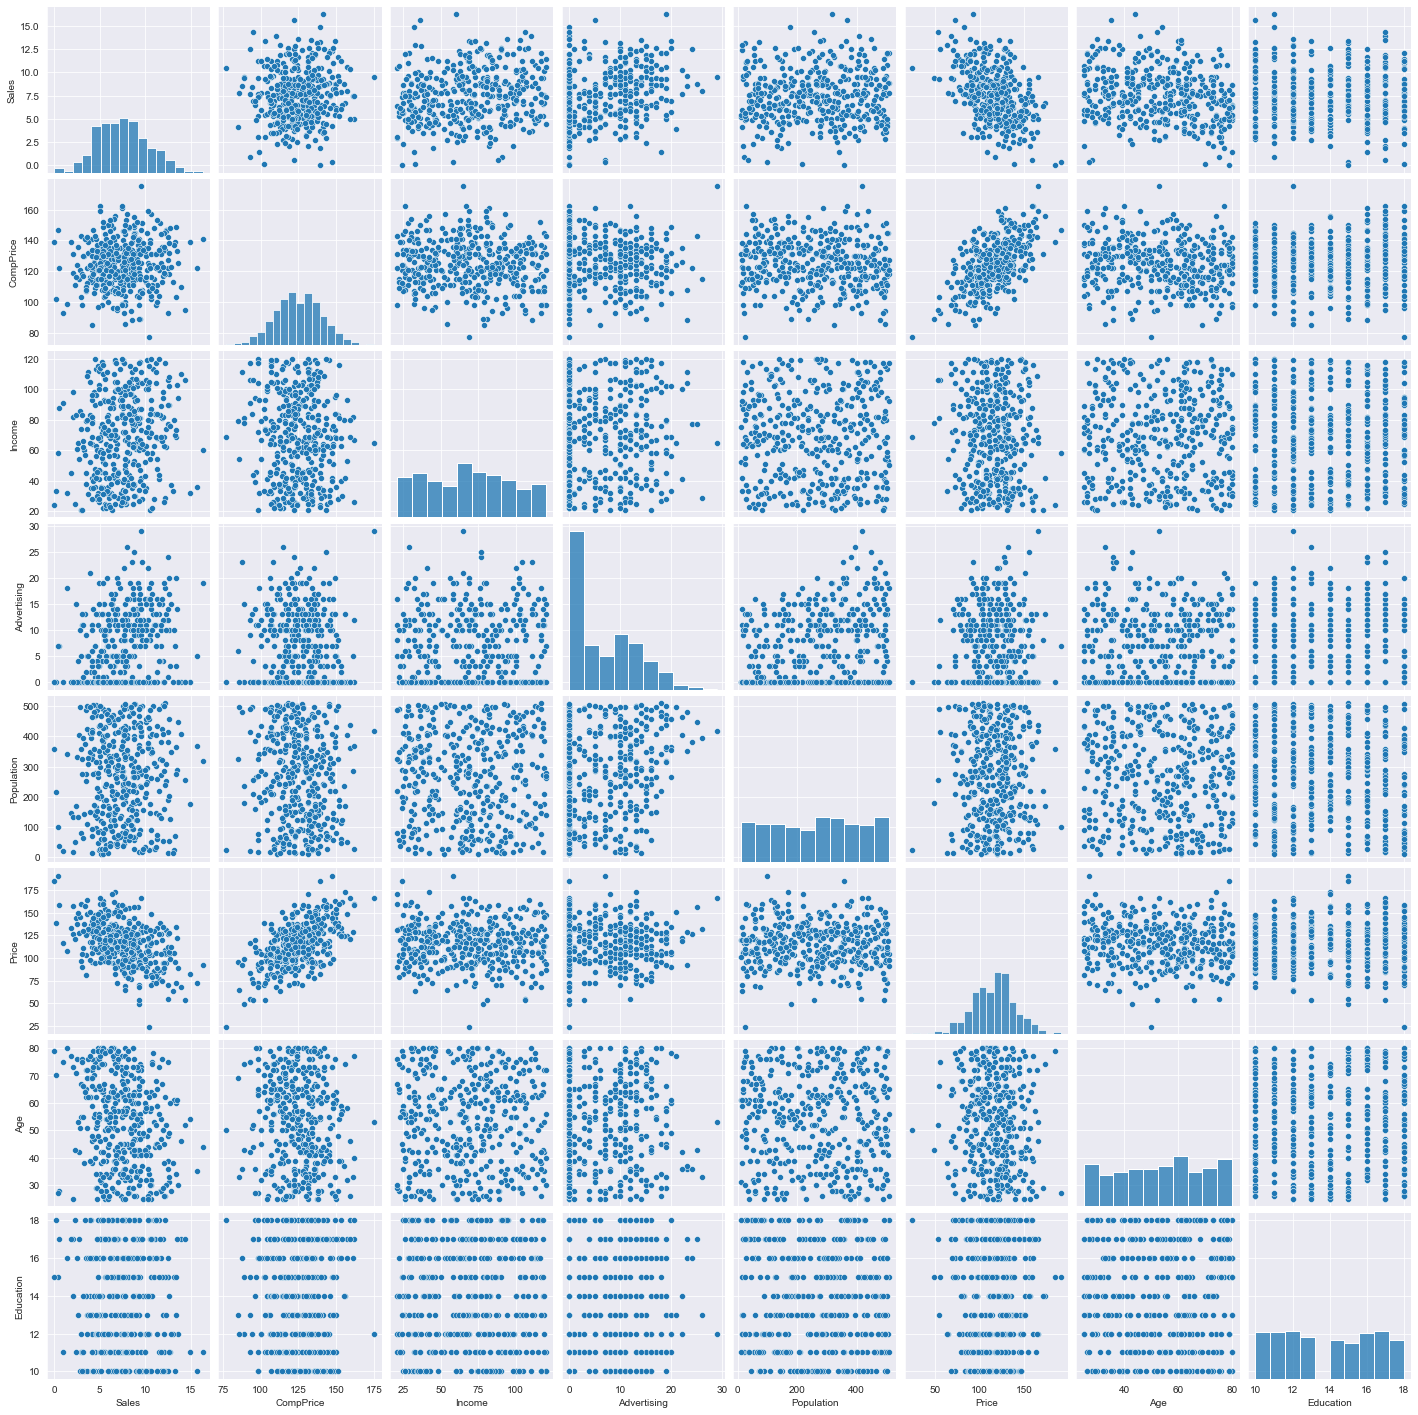

In [21]:
plt.figure(figsize=(8,8))
sns.pairplot(df, palette='coolwarm')
plt.show()


<AxesSubplot:>

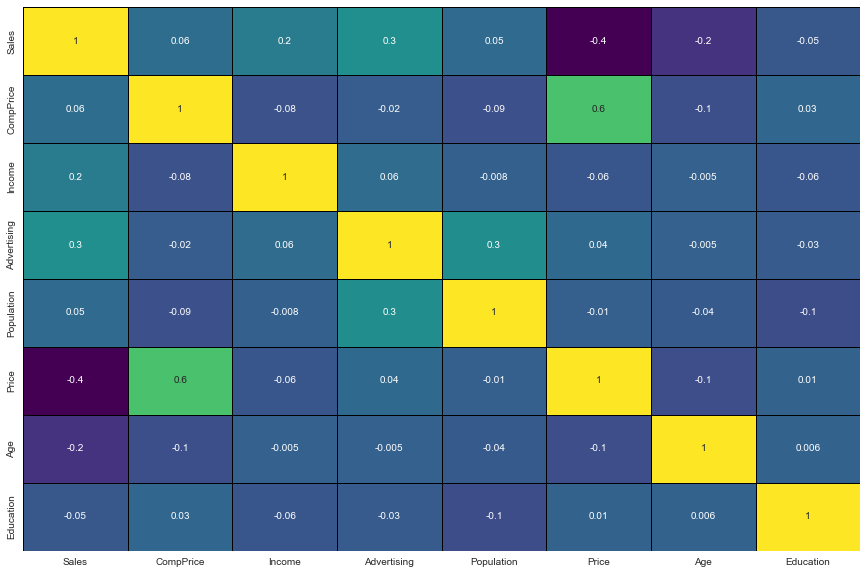

In [22]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

In [23]:
data_ = df1.copy()
data_.drop('Sales',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,138,73,11,276,120,42,17,1,0,0,0,1,0,1
1,111,48,16,260,83,65,10,0,1,0,0,1,0,1
2,113,35,10,269,80,59,12,0,0,1,0,1,0,1
3,117,100,4,466,97,55,14,0,0,1,0,1,0,1
4,141,64,3,340,128,38,13,1,0,0,0,1,1,0


## Feature Selection Technique
####  Data Pre-Processing

In [24]:
data_ = df1.copy()
data_.drop('Sales',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,138,73,11,276,120,42,17,1,0,0,0,1,0,1
1,111,48,16,260,83,65,10,0,1,0,0,1,0,1
2,113,35,10,269,80,59,12,0,0,1,0,1,0,1
3,117,100,4,466,97,55,14,0,0,1,0,1,0,1
4,141,64,3,340,128,38,13,1,0,0,0,1,1,0


In [25]:
data_['Sales'] = df1.Sales_cat
data_.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes,Sales
0,138,73,11,276,120,42,17,1,0,0,0,1,0,1,High
1,111,48,16,260,83,65,10,0,1,0,0,1,0,1,High
2,113,35,10,269,80,59,12,0,0,1,0,1,0,1,High
3,117,100,4,466,97,55,14,0,0,1,0,1,0,1,Medium
4,141,64,3,340,128,38,13,1,0,0,0,1,1,0,Low


In [26]:
le = LabelEncoder()
le.fit(data_["Sales"])
data_["Sales"]=le.transform(data_["Sales"])
data_.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes,Sales
0,138,73,11,276,120,42,17,1,0,0,0,1,0,1,0
1,111,48,16,260,83,65,10,0,1,0,0,1,0,1,0
2,113,35,10,269,80,59,12,0,0,1,0,1,0,1,0
3,117,100,4,466,97,55,14,0,0,1,0,1,0,1,2
4,141,64,3,340,128,38,13,1,0,0,0,1,1,0,1


In [28]:
# split into input (X) and output (y) variables
X = data_.iloc[:, :-1]

y=  data_.Sales

In [29]:
#Feature importance
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, chi2

In [30]:
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)

In [31]:
# summarize scores
scores = fit.scores_

features = fit.transform(X)

In [32]:
score_df = pd.DataFrame(list(zip(scores, X.columns)),
               columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
4,300.881058,Price
2,251.767458,Advertising
3,141.113336,Population
5,106.577639,Age
8,66.174919,ShelveLoc_Good
1,65.145403,Income
7,48.524460,ShelveLoc_Bad
12,13.109136,US_No
9,8.654770,ShelveLoc_Medium
13,7.215106,US_Yes


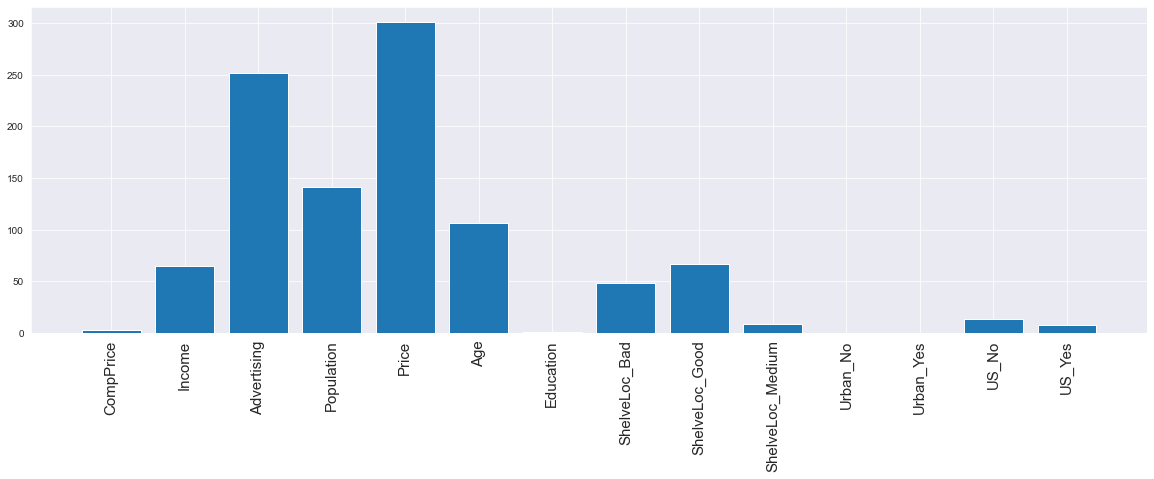

In [33]:
fig, axes = plt.subplots(figsize=(20, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
axes.set_xticklabels(X.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

In [34]:
model_data = data_[['Price', 'Advertising','Population', 'Income', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Bad', 'ShelveLoc_Medium','Sales']]
model_data.head()

,Price,Advertising,Population,Income,Age,ShelveLoc_Good,ShelveLoc_Bad,ShelveLoc_Medium,Sales
0,120,11,276,73,42,0,1,0,0
1,83,16,260,48,65,1,0,0,0
2,80,10,269,35,59,0,0,1,0
3,97,4,466,100,55,0,0,1,2
4,128,3,340,64,38,0,1,0,1


###  Random Forest Built-in Feature Importance

In [36]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)

#%%time
classifier_rf.fit(X, y)

# checking the oob score
print('checking the oob score',classifier_rf.oob_score_)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}
from sklearn.model_selection import GridSearchCV
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X, y)

print('Best Score',grid_search.best_score_)

rf_best = grid_search.best_estimator_
print(rf_best)

checking the oob score 0.635
Fitting 4 folds for each of 180 candidates, totalling 720 fits
Best Score 0.66
RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)


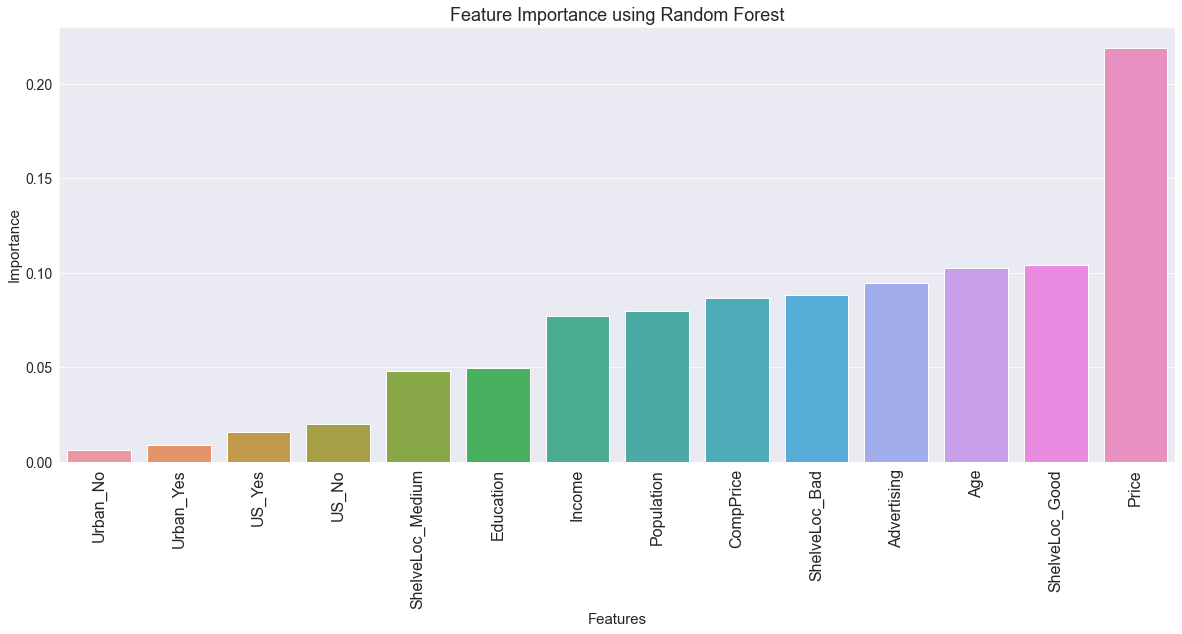

In [37]:
rf_best.feature_importances_
imp_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_best.feature_importances_
})

plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Importance", 
            data=imp_df, 
            order=imp_df.sort_values('Importance').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Importance using Random Forest", size=18)
plt.show()

### Test Train Split With Imbalanced Dataset

In [38]:
x = model_data.drop('Sales',axis=1)
y = model_data['Sales']

In [39]:
y.unique()

array([0, 2, 1])

In [40]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({2: 178, 0: 92, 1: 90}) Testing Data Counter({2: 20, 0: 10, 1: 10})


In [41]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [42]:
# summarize train and test composition
counter_train = Counter(y_train)
counter_test = Counter(y_test)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({2: 139, 0: 71, 1: 70}) Testing Data Counter({2: 59, 0: 31, 1: 30})


In [43]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (280, 8)
Shape of X_test:  (120, 8)
Shape of y_train:  (280,)
Shape of y_test (120,)


In [44]:
#base model
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [45]:
loc = np.array(score_array).max()
score_array.index(loc)+1

34

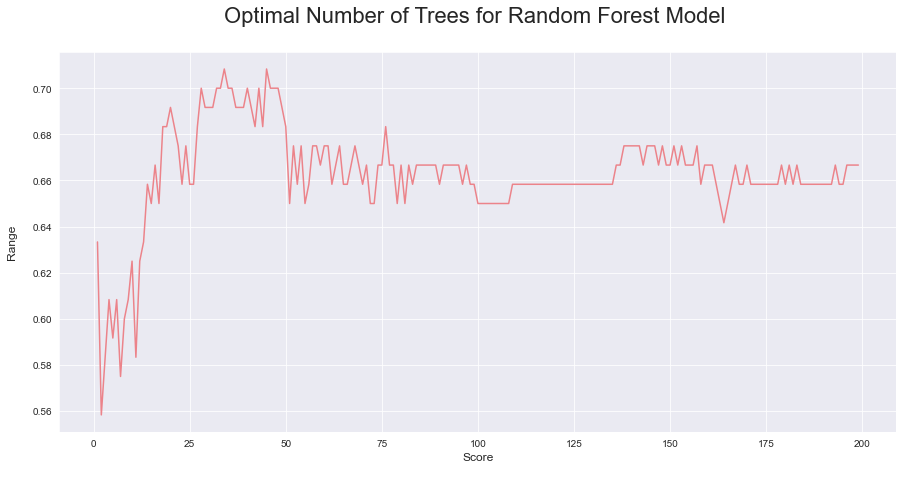

In [47]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

In [49]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

#print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
#print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 195, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True})


RandomForestClassifier(max_depth=50, min_samples_leaf=4, n_estimators=195)

In [50]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=50, min_samples_leaf=4, n_estimators=195,
                       random_state=42)

In [51]:
df1.Sales_cat.unique()

['High', 'Medium', 'Low']
Categories (3, object): ['Low' < 'Medium' < 'High']

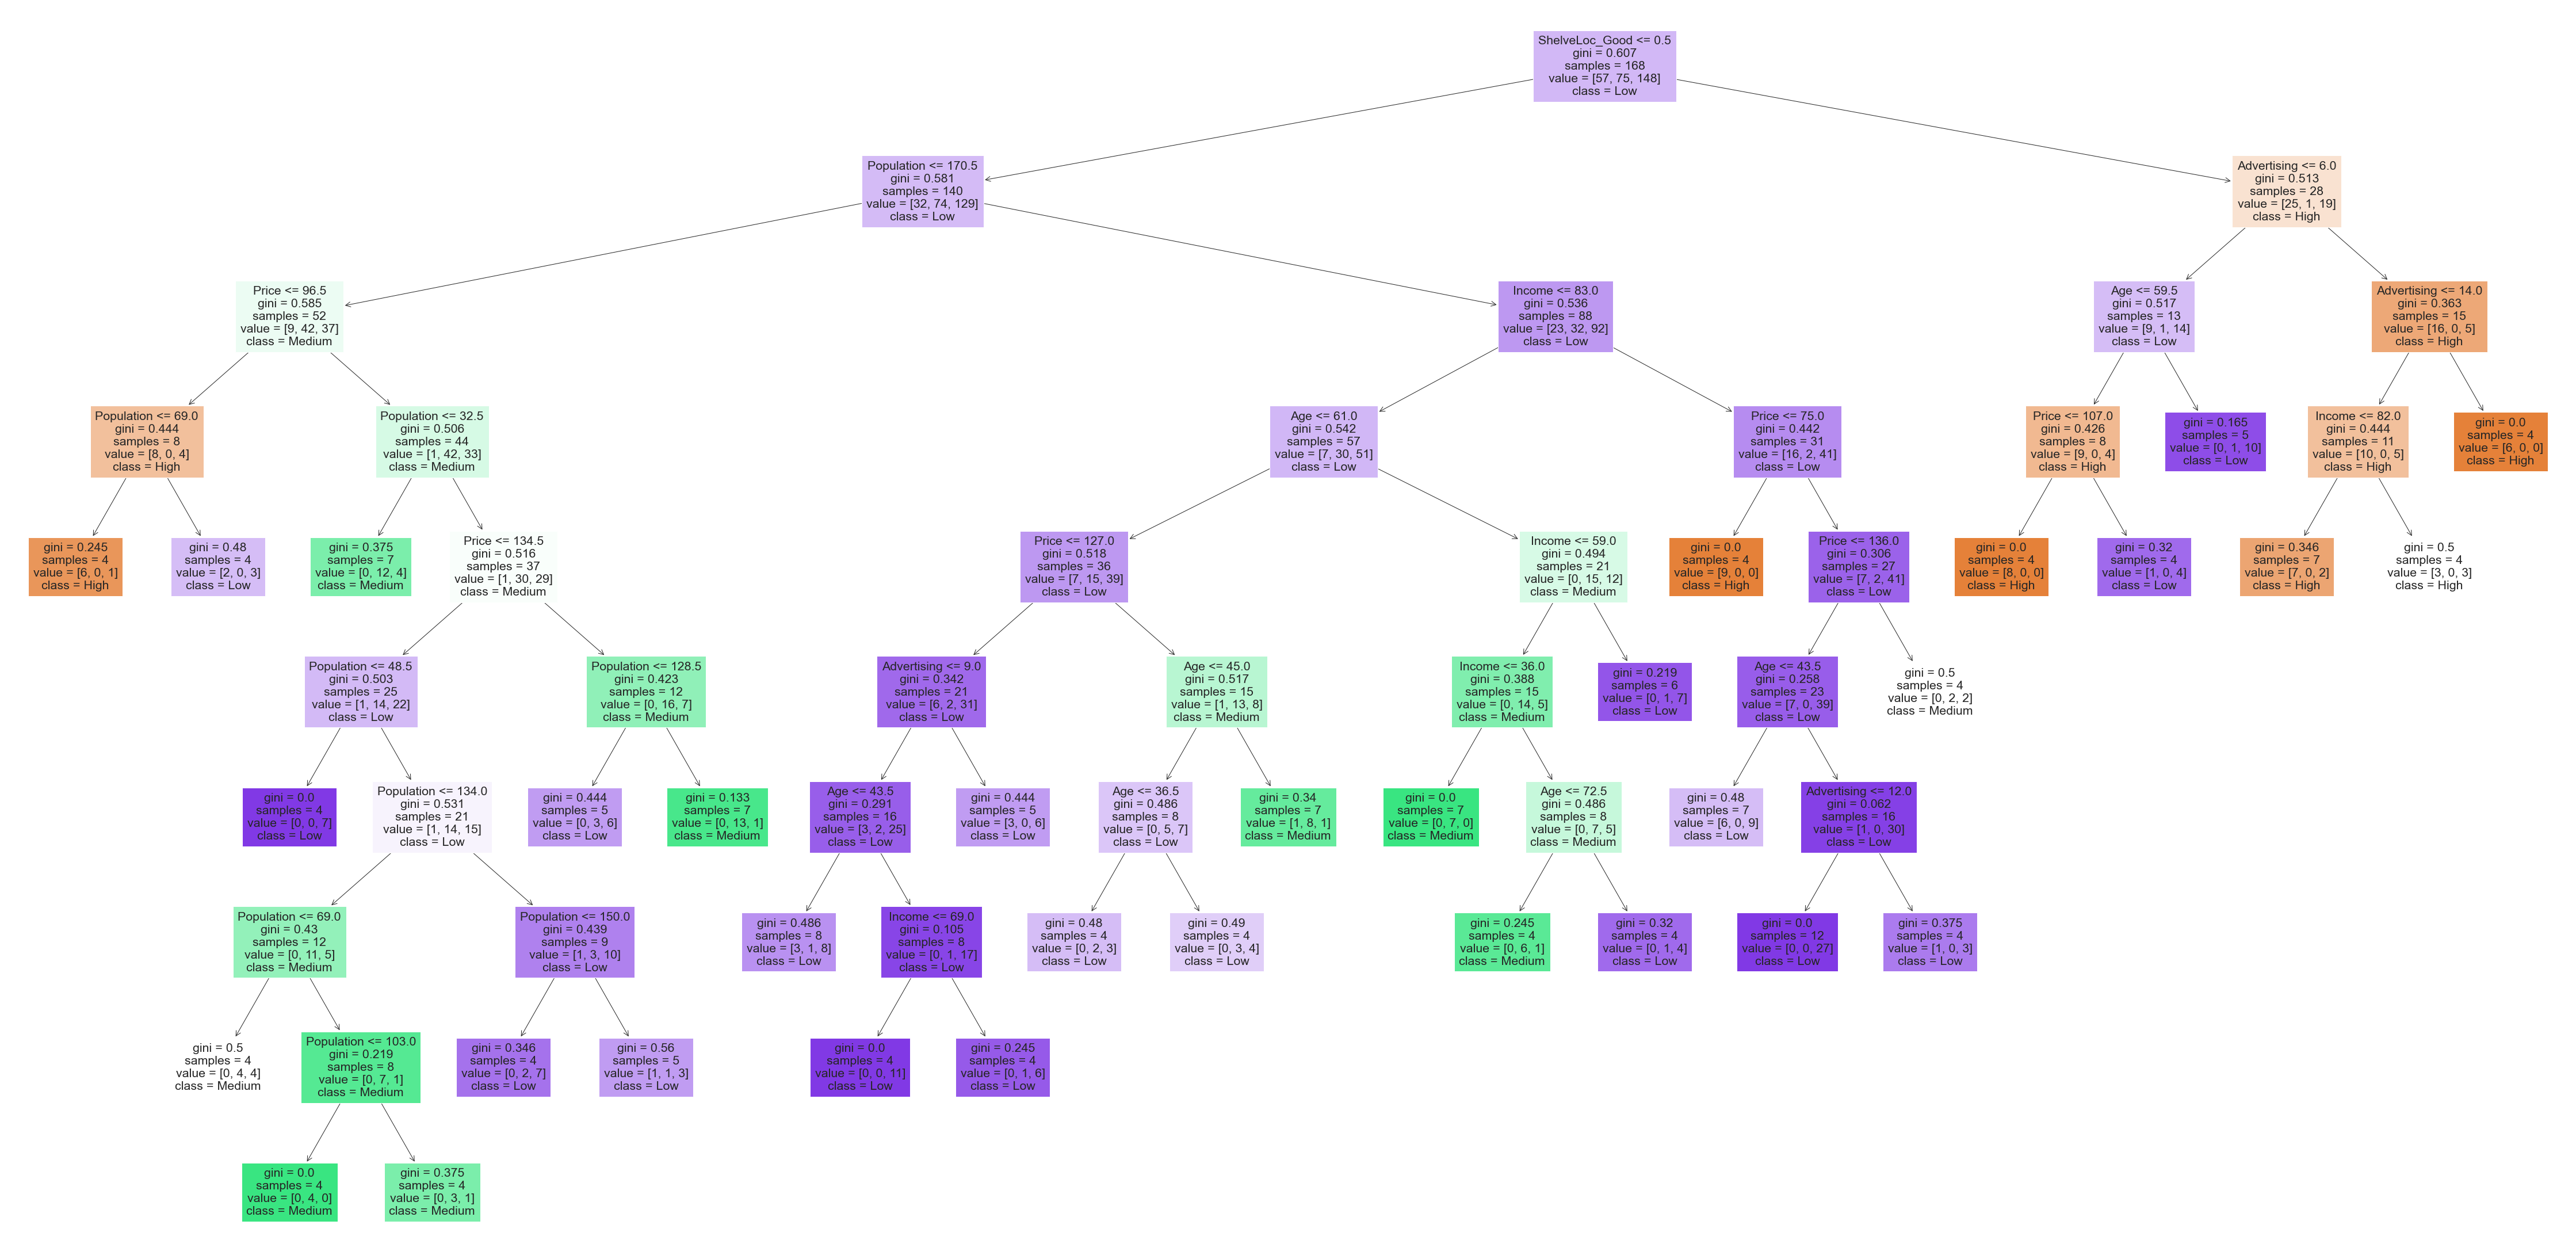

In [52]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[190], feature_names = model_data.columns,class_names=df1.Sales_cat.unique(),filled=True)
plt.show()